# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import datetime
import multiprocessing
from itertools import chain

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics as skmetrics
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import catboost as cb


from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import LancasterStemmer

import tensorflow as tf
from keras.metrics import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

#import shap

from xgboost import XGBClassifier
import catboost as cb

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import tukey_hsd
from scipy.spatial import distance
from decimal import Decimal

from sklearn.model_selection import cross_val_score

from operator import add


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/praxis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2023-07-25 17:23:06.304059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def euclidean(v1, v2):
    return sum((p-q)**2 for p, q in zip(v1, v2)) ** .5

In [3]:
cores = multiprocessing.cpu_count()

START = datetime.date(2010,9,1)
END = datetime.date(2010,10,31)

FUTURE_TEST_START = datetime.date(2010,11,1)
FUTURE_TEST_END = datetime.date(2010,11,10)


# Dataloading and Preprocessing

In [4]:
df1 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/logon.csv')
df2 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/device.csv')
df3 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/email.csv')
df4 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/file.csv')
df5 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/http.csv')
ans = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/answers/answers.csv')
ldap = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/ldap/2009-12.csv')
df6 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/psychometric.csv')


In [ ]:
df3['activity'] = "email"
df4['activity'] = "file"
df5['activity'] = "http"

Dropping all except the text data from web browsing.

In [ ]:
df3 = df3.drop(columns={'content'})
df4 = df4.drop(columns={'content'})

In [ ]:
df_merged = pd.concat([df1, df2, df3, df4, df5])
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['day_date'] = pd.to_datetime(df_merged['date']).dt.date

In [ ]:
df_time_range = df_merged[((df_merged['day_date'] >= START) & (df_merged['day_date'] <= END))]


In [ ]:
#TEST
df_future_test_time_range = df_merged[((df_merged['day_date'] >= FUTURE_TEST_START) & (df_merged['day_date'] <= FUTURE_TEST_END))]

In [ ]:
df_time_range['label'] = 'normal'
df_time_range.loc[df_time_range['id'].isin(ans['id']),['label']] = 'abnormal'


/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/1950934690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_range['label'] = 'normal'


In [ ]:
#TEST
df_future_test_time_range['label'] = 'normal'
df_future_test_time_range.loc[df_future_test_time_range['id'].isin(ans['id']),['label']] = 'abnormal'


/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/3425570710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_future_test_time_range['label'] = 'normal'


In [ ]:
userEvents = df_time_range
userEvents['activityMinute'] = userEvents['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
userEvents['activityMinute'] = userEvents['activityMinute'].apply(lambda s: (s/60))


/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2862026754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['activityMinute'] = userEvents['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2862026754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['activityMinute'] = userEvents['activityMinute'].apply(lambda s: (s/60))


In [ ]:
#TEST
userEvents_future_test = df_future_test_time_range
userEvents_future_test['activityMinute'] = userEvents_future_test['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
userEvents_future_test['activityMinute'] = userEvents_future_test['activityMinute'].apply(lambda s: (s/60))

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/1432260454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents_future_test['activityMinute'] = userEvents_future_test['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/1432260454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents_future_test['activityMinute'] = userEvents_future_test['activityMinute'].apply(lambda s

# NLP Prep

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
def prepare_text(pretext):
    tokens = word_tokenize(pretext, language="english", preserve_line=True)
    token_tag = pos_tag(tokens)
    include_tags = ['VBN', 'VBD', 'JJ', 'JJS', 'JJR', 'CD', 'NN', 'NNS', 'NNP', 'NNPS']
    filtered_tokens = (tok for tok, tag in token_tag if tag in include_tags)    
    stemmed_tokens = (lancaster.stem(tok) for tok in filtered_tokens)
    lemmed_words = (lemmatizer.lemmatize(tok) for tok in stemmed_tokens)
    lower_words = [str.lower(tok) for tok in lemmed_words]
    joined = " ".join(lower_words)
    return(joined)
lancaster = LancasterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
userEvents['content'].fillna('', inplace=True)
userEvents['tokenized'] = userEvents['content'].apply(prepare_text)
nltk.download('stopwords')
stops = set(stopwords.words('english'))

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/3075726431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['content'].fillna('', inplace=True)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/3075726431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['tokenized'] = userEvents['content'].apply(prepare_text)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#TEST
userEvents_future_test['content'].fillna('', inplace=True)
userEvents_future_test['tokenized'] = userEvents_future_test['content'].apply(prepare_text)
nltk.download('stopwords')
stops = set(stopwords.words('english'))

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/1992499886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents_future_test['content'].fillna('', inplace=True)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/1992499886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents_future_test['tokenized'] = userEvents_future_test['content'].apply(prepare_text)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# INDIVIDUAL ANALYSIS

In [ ]:
dates = userEvents['day_date']
dates = dates.unique()

In [ ]:
INTERVAL=1440
dateActivity = []
for d in dates:
    dayEvents = userEvents.loc[(userEvents['day_date'] == d)]
    users = dayEvents['user']
    users = users.unique()
    for u in users:
        label = 0
        dailyActivityMatrix = []
        userdf = dayEvents.loc[(dayEvents['user'] == u)]
        for i in range(0, 1440, INTERVAL):
            bin_Events = userdf.loc[(userdf['activityMinute'] >= i ) & (userdf['activityMinute'] < (i + INTERVAL))]
            connect_count = bin_Events[bin_Events['activity'] == 'Connect'].shape[0]
            disconnect_count = bin_Events[bin_Events['activity'] == 'Disconnect'].shape[0]
            login_count = bin_Events[bin_Events['activity'] == 'Logon'].shape[0]
            logout_count = bin_Events[bin_Events['activity'] == 'Logoff'].shape[0]
            email_count = bin_Events[bin_Events['activity'] == 'email'].shape[0]
            file_count = bin_Events[bin_Events['activity'] == 'file'].shape[0]
            http_count = bin_Events[bin_Events['activity'] == 'http'].shape[0]
            intervalList = [connect_count, login_count, logout_count, email_count, file_count, http_count, disconnect_count]
            dailyActivityMatrix.append(intervalList)
            if (bin_Events[(bin_Events['label'] == 'abnormal')].shape[0] > 0): label = 1
            text = ' '.join(bin_Events['tokenized'])
        dateActivity.append([d, u, dailyActivityMatrix, text, label])

In [ ]:
final = pd.DataFrame(dateActivity, columns=['date', 'user', 'dailyActivityMatrix', 'text', 'label'])
final['dailyActivityMatrix'] = final['dailyActivityMatrix'].apply(lambda y: (list(chain.from_iterable(y))))
df_temp = pd.DataFrame(final['dailyActivityMatrix'].tolist())
df_final = pd.DataFrame()
df_final = final.join(df_temp)

In [ ]:
df_final.dropna(inplace=True)

In [ ]:
df_final['text'] = df_final['text'].replace(r'\s+', ' ', regex=True)

In [ ]:
#TEST
dates = userEvents_future_test['day_date']
dates = dates.unique()

In [ ]:
#TEST
INTERVAL=1440
dateActivity = []
for d in dates:
    dayEvents = userEvents_future_test.loc[(userEvents_future_test['day_date'] == d)]
    users = dayEvents['user']
    users = users.unique()
    for u in users:
        label = 0
        dailyActivityMatrix = []
        userdf = dayEvents.loc[(dayEvents['user'] == u)]
        for i in range(0, 1440, INTERVAL):
            bin_Events = userdf.loc[(userdf['activityMinute'] >= i ) & (userdf['activityMinute'] < (i + INTERVAL))]
            connect_count = bin_Events[bin_Events['activity'] == 'Connect'].shape[0]
            disconnect_count = bin_Events[bin_Events['activity'] == 'Disconnect'].shape[0]
            login_count = bin_Events[bin_Events['activity'] == 'Logon'].shape[0]
            logout_count = bin_Events[bin_Events['activity'] == 'Logoff'].shape[0]
            email_count = bin_Events[bin_Events['activity'] == 'email'].shape[0]
            file_count = bin_Events[bin_Events['activity'] == 'file'].shape[0]
            http_count = bin_Events[bin_Events['activity'] == 'http'].shape[0]
            intervalList = [connect_count, login_count, logout_count, email_count, file_count, http_count, disconnect_count]
            dailyActivityMatrix.append(intervalList)
            if (bin_Events[(bin_Events['label'] == 'abnormal')].shape[0] > 0): label = 1
            text = ' '.join(bin_Events['tokenized'])
        dateActivity.append([d, u, dailyActivityMatrix, text, label])

In [ ]:
#TEST
final_test = pd.DataFrame(dateActivity, columns=['date', 'user', 'dailyActivityMatrix', 'text', 'label'])
final_test['dailyActivityMatrix'] = final_test['dailyActivityMatrix'].apply(lambda y: (list(chain.from_iterable(y))))
df_temp_test = pd.DataFrame(final_test['dailyActivityMatrix'].tolist())
df_final_test = pd.DataFrame()
df_final_test = final_test.join(df_temp_test)

In [ ]:
#TEST
df_final_test.dropna(inplace=True)

In [ ]:
#TEST
df_final_test['text'] = df_final_test['text'].replace(r'\s+', ' ', regex=True)

In [ ]:
users = df_final['user']
users = users.unique()

DAYS_PAST = 1
indPastActivity = pd.DataFrame()
for u in users:
    userevents = final.loc[(final['user'] == u)]
    vector_activity = userevents.loc[:, ['dailyActivityMatrix']]
    vector_past_activity = vector_activity.shift(DAYS_PAST)
    vector_past_activity = vector_past_activity.rename(columns={'dailyActivityMatrix':'dailyActivityMatrixPast'})

    events = userevents.filter(['user', 'date'])
    events = events.join(vector_past_activity)
    indPastActivity = pd.concat([indPastActivity, events])

In [ ]:
df_final = pd.merge(df_final, indPastActivity, on=['user', 'date'], how='left')
df_final = df_final[df_final['dailyActivityMatrixPast'].notna()]

In [ ]:
distances = []
for i in range(0, df_final.shape[0]):
    distances.append(euclidean(df_final.iloc[i]['dailyActivityMatrix'], df_final.iloc[i]['dailyActivityMatrixPast']))
df_final['ind2past'] = distances

In [ ]:
df_final['ind2past_mean'] = df_final.ind2past.rolling(window=5,min_periods=0,closed='left').mean()
df_final['ind2past_mean_dist'] = abs(df_final['ind2past'] - df_final['ind2past_mean'])

In [ ]:
#TEST
users = df_final_test['user']
users = users.unique()

DAYS_PAST = 1
indPastActivity = pd.DataFrame()
for u in users:
    userevents = final_test.loc[(final_test['user'] == u)]
    vector_activity = userevents.loc[:, ['dailyActivityMatrix']]
    vector_past_activity = vector_activity.shift(DAYS_PAST)
    vector_past_activity = vector_past_activity.rename(columns={'dailyActivityMatrix':'dailyActivityMatrixPast'})

    events = userevents.filter(['user', 'date'])
    events = events.join(vector_past_activity)
    indPastActivity = pd.concat([indPastActivity, events])

In [ ]:
#TEST
df_final_test = pd.merge(df_final_test, indPastActivity, on=['user', 'date'], how='left')
df_final_test = df_final_test[df_final_test['dailyActivityMatrixPast'].notna()]

In [ ]:
#TEST
distances = []
for i in range(0, df_final_test.shape[0]):
    distances.append(euclidean(df_final_test.iloc[i]['dailyActivityMatrix'], df_final_test.iloc[i]['dailyActivityMatrixPast']))
df_final_test['ind2past'] = distances

In [ ]:
#TEST
df_final_test['ind2past_mean'] = df_final_test.ind2past.rolling(window=5,min_periods=0,closed='left').mean()
df_final_test['ind2past_mean_dist'] = abs(df_final_test['ind2past'] - df_final_test['ind2past_mean'])

In [ ]:
df_final.dropna(how='any', inplace=True)

In [ ]:
#TEST
df_final_test.dropna(how='any', inplace=True)

In [ ]:
#Bringing in the LDAP and Group Data
ldap = ldap.rename(columns={'user_id': 'user'})

In [ ]:
df_final = pd.merge(df_final, ldap, on='user', how='left')

In [ ]:
#TEST
df_final_test = pd.merge(df_final_test, ldap, on='user', how='left')

In [ ]:
#Bringing in the Psychometric Data
df6.rename(columns={'user_id': 'user'}, inplace=True)

In [ ]:
df_final = pd.merge(df_final, df6, on='user', how='left')

In [ ]:
#TEST
df_final_test = pd.merge(df_final_test, df6, on='user', how='left')

In [ ]:
df_final['department'].fillna("other", inplace=True)
df_final['role'].fillna("other", inplace=True)

In [ ]:
#TEST
df_final_test['department'].fillna("other", inplace=True)
df_final_test['role'].fillna("other", inplace=True)

In [ ]:
role_mean = []
dates = df_final['date']
dates = dates.unique()
for d in dates:
    dayEvents = df_final.loc[(df_final['date'] == d)]
    roles = dayEvents['role']
    roles = roles.unique()
    for r in roles:
        roleEvents = dayEvents.loc[(dayEvents['role']) == r]
        tempMatrix = [0] * 7
        for index, row in roleEvents.iterrows():
            tempMatrix = list(map(add, row['dailyActivityMatrix'], tempMatrix))
        size = roleEvents.shape[0]
        if (roleEvents.shape[0] > 0):
            tempMatrix = [x/roleEvents.shape[0] for x in tempMatrix]
        role_mean.append([d, r, tempMatrix])
role_mean_train_df = pd.DataFrame(role_mean, columns=['date', 'role', 'roleActivityMatrix'])
df_final = pd.merge(df_final, role_mean_train_df, on=['date', 'role'], how='left')

distances = []
for i in range(0, df_final.shape[0]):
    distances.append(euclidean(df_final.iloc[i]['dailyActivityMatrix'], df_final.iloc[i]['roleActivityMatrix']))
df_final['ind2role'] = distances

In [ ]:
#TEST
role_mean = []
dates = df_final_test['date']
dates = dates.unique()
for d in dates:
    dayEvents = df_final_test.loc[(df_final_test['date'] == d)]
    roles = dayEvents['role']
    roles = roles.unique()
    for r in roles:
        roleEvents = dayEvents.loc[(dayEvents['role']) == r]
        tempMatrix = [0] * 7
        for index, row in roleEvents.iterrows():
            tempMatrix = list(map(add, row['dailyActivityMatrix'], tempMatrix))
        size = roleEvents.shape[0]
        if (roleEvents.shape[0] > 0):
            tempMatrix = [x/roleEvents.shape[0] for x in tempMatrix]
        role_mean.append([d, r, tempMatrix])
role_mean_train_df = pd.DataFrame(role_mean, columns=['date', 'role', 'roleActivityMatrix'])
df_final_test = pd.merge(df_final_test, role_mean_train_df, on=['date', 'role'], how='left')

distances = []
for i in range(0, df_final_test.shape[0]):
    distances.append(euclidean(df_final_test.iloc[i]['dailyActivityMatrix'], df_final_test.iloc[i]['roleActivityMatrix']))
df_final_test['ind2role'] = distances

In [ ]:
users = df_final['user']
users = users.unique()

ind2RolePast = pd.DataFrame()
for u in users:
    userevents = df_final.loc[(df_final['user'] == u)]
    userevents['i2rd'] = abs(userevents['ind2role'] - userevents.shift(DAYS_PAST)['ind2role'])
    userevents = userevents[['user', 'date', 'i2rd']]
    ind2RolePast = pd.concat([ind2RolePast, userevents])

df_final = pd.merge(df_final, ind2RolePast, on=['user', 'date'], how='left')

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2618607889.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userevents['i2rd'] = abs(userevents['ind2role'] - userevents.shift(DAYS_PAST)['ind2role'])
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2618607889.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userevents['i2rd'] = abs(userevents['ind2role'] - userevents.shift(DAYS_PAST)['ind2role'])
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/261860788

In [ ]:
#TEST

users = df_final_test['user']
users = users.unique()

ind2RolePast = pd.DataFrame()
for u in users:
    userevents = df_final_test.loc[(df_final_test['user'] == u)]
    userevents['i2rd'] = abs(userevents['ind2role'] - userevents.shift(DAYS_PAST)['ind2role'])
    userevents = userevents[['user', 'date', 'i2rd']]
    ind2RolePast = pd.concat([ind2RolePast, userevents])

df_final_test = pd.merge(df_final_test, ind2RolePast, on=['user', 'date'], how='left')

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2212108003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userevents['i2rd'] = abs(userevents['ind2role'] - userevents.shift(DAYS_PAST)['ind2role'])
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2212108003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userevents['i2rd'] = abs(userevents['ind2role'] - userevents.shift(DAYS_PAST)['ind2role'])
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/221210800

In [ ]:
dates = df_final['date']
dates = dates.unique()

dept_mean = []
for d in dates:
    dayEvents = df_final.loc[(df_final['date'] == d)]
    depts = dayEvents['department']
    depts = depts.unique()
    for e in depts:
        deptEvents = dayEvents.loc[(dayEvents['department']) == e]
        tempMatrix = [0] * 7
        for index, row in deptEvents.iterrows():
            tempMatrix = list(map(add, row['dailyActivityMatrix'], tempMatrix))
        size = deptEvents.shape[0]
        if (deptEvents.shape[0] > 0):
            tempMatrix = [x/deptEvents.shape[0] for x in tempMatrix]
        dept_mean.append([d, e, tempMatrix])
dept_mean_df = pd.DataFrame(dept_mean, columns=['date', 'department', 'deptActivityMatrix'])
df_final = pd.merge(df_final, dept_mean_df, on=['date', 'department'], how='left')
distances = []
for i in range(0, df_final.shape[0]):
    distances.append(euclidean(df_final.iloc[i]['dailyActivityMatrix'], df_final.iloc[i]['deptActivityMatrix']))
df_final['ind2dept'] = distances

In [ ]:
users = df_final['user']
users = users.unique()

ind2DeptPast = pd.DataFrame()
for u in users:
    userevents = df_final.loc[(df_final['user'] == u)]
    userevents['i2dd'] = abs(userevents['ind2dept'] - userevents.shift(DAYS_PAST)['ind2dept'])
    userevents = userevents[['user', 'date', 'i2dd']]
    ind2DeptPast = pd.concat([ind2DeptPast, userevents])

df_final = pd.merge(df_final, ind2DeptPast, on=['user', 'date'], how='left')

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/3835278777.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userevents['i2dd'] = abs(userevents['ind2dept'] - userevents.shift(DAYS_PAST)['ind2dept'])
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/3835278777.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userevents['i2dd'] = abs(userevents['ind2dept'] - userevents.shift(DAYS_PAST)['ind2dept'])
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/383527877

In [ ]:
#TEST

dates = df_final_test['date']
dates = dates.unique()

dept_mean = []
for d in dates:
    dayEvents = df_final_test.loc[(df_final_test['date'] == d)]
    depts = dayEvents['department']
    depts = depts.unique()
    for e in depts:
        deptEvents = dayEvents.loc[(dayEvents['department']) == e]
        tempMatrix = [0] * 7
        for index, row in deptEvents.iterrows():
            tempMatrix = list(map(add, row['dailyActivityMatrix'], tempMatrix))
        size = deptEvents.shape[0]
        if (deptEvents.shape[0] > 0):
            tempMatrix = [x/deptEvents.shape[0] for x in tempMatrix]
        dept_mean.append([d, e, tempMatrix])
dept_mean_df = pd.DataFrame(dept_mean, columns=['date', 'department', 'deptActivityMatrix'])
df_final_test = pd.merge(df_final_test, dept_mean_df, on=['date', 'department'], how='left')
distances = []
for i in range(0, df_final_test.shape[0]):
    distances.append(euclidean(df_final_test.iloc[i]['dailyActivityMatrix'], df_final_test.iloc[i]['deptActivityMatrix']))
df_final_test['ind2dept'] = distances

In [ ]:
#TEST
users = df_final_test['user']
users = users.unique()

ind2DeptPast = pd.DataFrame()
for u in users:
    userevents = df_final_test.loc[(df_final_test['user'] == u)]
    userevents['i2dd'] = abs(userevents['ind2dept'] - userevents.shift(DAYS_PAST)['ind2dept'])
    userevents = userevents[['user', 'date', 'i2dd']]
    ind2DeptPast = pd.concat([ind2DeptPast, userevents])

df_final_test = pd.merge(df_final_test, ind2DeptPast, on=['user', 'date'], how='left')

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2588891935.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userevents['i2dd'] = abs(userevents['ind2dept'] - userevents.shift(DAYS_PAST)['ind2dept'])
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2588891935.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userevents['i2dd'] = abs(userevents['ind2dept'] - userevents.shift(DAYS_PAST)['ind2dept'])
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/258889193

In [ ]:
df_final['text'].replace(' ', np.nan, inplace=True)
df_final ['text'].replace('', np.nan, inplace=True)

In [ ]:
df = df_final.copy()
df.dropna(subset=['text', 'i2dd', 'i2rd'], inplace=True)
X = df.drop(columns=['label'])
y = df['label']

In [ ]:
#TEST
df_final_test['text'].replace(' ', np.nan, inplace=True)
df_final_test ['text'].replace('', np.nan, inplace=True)


In [ ]:
#TEST
df_future_test = df_final_test.copy()
df_future_test.dropna(subset=['text', 'i2dd', 'i2rd'], inplace=True)
X_future_test = df_future_test.drop(columns=['label'])
y_future_test = df_future_test['label']

# # START HERE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
tfidfvectorizer = TfidfVectorizer(stop_words='english', analyzer='word' )

role = X_train['role']
role = role.unique()
temp_df = pd.DataFrame()
for r in role:
    train_text = X_train.loc[(X_train['role'] == r)]
    train_tfidf = tfidfvectorizer.fit_transform(train_text['text'])    
    train_text['tfidf_mean'] = ((train_tfidf.sum(axis=1).transpose()) / (train_tfidf.getnnz(axis=1))).transpose()
    train_text = train_text[['tfidf_mean', 'user', 'date']]
    temp_df = pd.concat([temp_df, train_text])    
X_train = pd.merge(X_train, temp_df, how='left', on=['user', 'date'])
    
role = X_test['role']
role = role.unique()
temp_df = pd.DataFrame()
for r in role:
    test_text = X_test.loc[(X_test['role'] == r)]
    test_tfidf_df = tfidfvectorizer.transform(test_text['text'])    
    test_text['tfidf_mean'] = ((test_tfidf_df.sum(axis=1).transpose()) / (test_tfidf_df.getnnz(axis=1))).transpose()
    test_text = test_text[['tfidf_mean', 'user', 'date']]
    temp_df = pd.concat([temp_df, test_text])
X_test = pd.merge(X_test, temp_df, how='left', on=['user', 'date'])


NameError: name 'TfidfVectorizer' is not defined

In [ ]:
dept = X_train['department']
dept = dept.unique()
temp_df = pd.DataFrame()
for e in dept:
    train_text = X_train.loc[(X_train['department'] == e)]
    train_tfidf = tfidfvectorizer.fit_transform(train_text['text'])    
    train_text['tfidf_mean_dept'] = ((train_tfidf.sum(axis=1).transpose()) / (train_tfidf.getnnz(axis=1))).transpose()
    train_text = train_text[['tfidf_mean_dept', 'user', 'date']]
    temp_df = pd.concat([temp_df, train_text])    
X_train = pd.merge(X_train, temp_df, how='left', on=['user', 'date'])

dept = X_test['department']
dept = dept.unique()
temp_df = pd.DataFrame()
for e in dept:
    test_text = X_test.loc[(X_test['department'] == e)]
    test_tfidf_df = tfidfvectorizer.transform(test_text['text'])    
    test_text['tfidf_mean_dept'] = ((test_tfidf_df.sum(axis=1).transpose()) / (test_tfidf_df.getnnz(axis=1))).transpose()
    test_text = test_text[['tfidf_mean_dept', 'user', 'date']]
    temp_df = pd.concat([temp_df, test_text])
X_test = pd.merge(X_test, temp_df, how='left', on=['user', 'date'])


/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/1325875149.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text['tfidf_mean_dept'] = ((train_tfidf.sum(axis=1).transpose()) / (train_tfidf.getnnz(axis=1))).transpose()
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/1325875149.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text['tfidf_mean_dept'] = ((train_tfidf.sum(axis=1).transpose()) / (train_tfidf.getnnz(axis=1))).transpose()
/var/folders/p4/svf85_b50j

In [ ]:
X_train.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
                 'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past_mean'], inplace=True)
X_test.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
                 'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past_mean'], inplace=True)
# X_train.drop(columns=['ind2past', 'ind2role', 'ind2dept'], inplace=True)
# X_test.drop(columns=['ind2past', 'ind2role', 'ind2dept'], inplace=True)
# X_train.drop(columns=['tfidf_mean', 'tfidf_mean_dept'], inplace=True)
# X_test.drop(columns=['tfidf_mean', 'tfidf_mean_dept'], inplace=True)
# X_train.drop(columns=['O', 'C', 'E', 'A', 'N'], inplace=True)
# X_test.drop(columns=['O', 'C', 'E', 'A', 'N'], inplace=True)
# X_train.drop(X_train.iloc[:, 0:7],axis=1,inplace=True)
# X_test.drop(X_test.iloc[:, 0:7],axis=1,inplace=True)
X_train.rename(columns={0: 'login', 1: 'logout', 2: 'connect', 3: 'disconnect', 4: 'email', 5: 'file', 6: 'http' }, inplace=True)
X_test.rename(columns={0: 'login', 1: 'logout', 2: 'connect', 3: 'disconnect', 4: 'email', 5: 'file', 6: 'http' }, inplace=True)
# X_train.drop(columns=['i2rd', 'i2dd'], inplace=True)
# X_test.drop(columns=['i2rd', 'i2dd'], inplace=True)
# X_train.drop(columns=['ind2past_mean_dist'], inplace=True)
# X_test.drop(columns=['ind2past_mean_dist'], inplace=True)


columns = X_train.columns
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.set_axis(columns, axis=1,inplace=True)
X_test.set_axis(columns, axis=1,inplace=True)


/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2288596067.py:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  X_train.set_axis(columns, axis=1,inplace=True)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2288596067.py:32: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  X_test.set_axis(columns, axis=1,inplace=True)


In [ ]:
smote = SMOTE(k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

blsmote = BorderlineSMOTE(k_neighbors=5)
X_blsmote, y_blsmote = blsmote.fit_resample(X_train, y_train)

adasyn = ADASYN(n_neighbors=5)
X_ada, y_ada = adasyn.fit_resample(X_train, y_train)

In [ ]:
X_train_uav = X_train.copy()
X_test_uav = X_test.copy()

X_smote_uav = X_smote.copy()

X_blsmote_uav = X_blsmote.copy()

X_ada_uav = X_ada.copy()

In [ ]:

stuff = [X_train_uav, X_test_uav, X_smote_uav, X_blsmote_uav, X_ada_uav]

for x in stuff:
    x.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
                 'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past', 'ind2role', 'ind2dept',
                 'tfidf_mean', 'tfidf_mean_dept', 'ind2past_mean', 'ind2past_mean_dist', 'i2rd', 'i2dd', 'O', 'C',	'E', 'A', 'N'
                 ], inplace=True)

# X_train_uav.drop(columns=['date', 'role', 'user',
#                  'dailyActivityMatrix', 'business_unit', 
#                  'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
#                  'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past', 'ind2role', 'ind2dept',
#                  'tfidf_mean', 'tfidf_mean_dept', 'ind2past_mean', 'ind2past_mean_dist', 'i2rd', 'i2dd', 'O', 'C',	'E', 'A', 'N'
#                  ], inplace=True)

# X_test_uav.drop(columns=['date', 'role', 'user',
#                  'dailyActivityMatrix', 'business_unit', 
#                  'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
#                  'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past', 'ind2role', 'ind2dept',
#                  'tfidf_mean', 'tfidf_mean_dept', 'ind2past_mean', 'ind2past_mean_dist', 'i2rd', 'i2dd', 'O', 'C',	'E', 'A', 'N'], inplace=True)


# X_smote_uav.drop(columns=['date', 'role', 'user',
#                  'dailyActivityMatrix', 'business_unit', 
#                  'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
#                  'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past', 'ind2role', 'ind2dept',
#                  'tfidf_mean', 'tfidf_mean_dept', 'ind2past_mean', 'ind2past_mean_dist', 'i2rd', 'i2dd', 'O', 'C',	'E', 'A', 'N'
#                  ], inplace=True)


# X_blsmote_uav.drop(columns=['date', 'role', 'user',
#                  'dailyActivityMatrix', 'business_unit', 
#                  'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
#                  'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past', 'ind2role', 'ind2dept',
#                  'tfidf_mean', 'tfidf_mean_dept', 'ind2past_mean', 'ind2past_mean_dist', 'i2rd', 'i2dd', 'O', 'C',	'E', 'A', 'N'
#                  ], inplace=True)

# X_ada_uav.drop(columns=['date', 'role', 'user',
#                  'dailyActivityMatrix', 'business_unit', 
#                  'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
#                  'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past', 'ind2role', 'ind2dept',
#                  'tfidf_mean', 'tfidf_mean_dept', 'ind2past_mean', 'ind2past_mean_dist', 'i2rd', 'i2dd', 'O', 'C',	'E', 'A', 'N'
#                  ], inplace=True)



/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2379565592.py:24: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  X_train_uav.set_axis(columns, axis=1,inplace=True)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_40230/2379565592.py:25: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  X_test_uav.set_axis(columns, axis=1,inplace=True)


In [ ]:
X_train.columns

NameError: name 'X_train' is not defined

# Run ML Models

In [ ]:
# adacboost = AdaBoostClassifier(n_estimators=100)
# catboost = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy')


In [ ]:
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5],
    "objective": ['binary:logistic']
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
xgboost = XGBClassifier()
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=10, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
xgb_best_est = grid_result.best_estimator_

In [ ]:
catboost = cb()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = catboost.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

cat_best_est = grid_result.best_estimator_

Learning rate set to 0.041885
0:	learn: 0.9945693	total: 11.8ms	remaining: 11.8s
1:	learn: 0.9945693	total: 19.6ms	remaining: 9.8s
2:	learn: 0.9945693	total: 24.6ms	remaining: 8.18s
3:	learn: 0.9945693	total: 29.7ms	remaining: 7.4s
4:	learn: 0.9945693	total: 37.1ms	remaining: 7.38s
5:	learn: 0.9945693	total: 43.3ms	remaining: 7.17s
6:	learn: 0.9945693	total: 49.4ms	remaining: 7.01s
7:	learn: 0.9945693	total: 62.7ms	remaining: 7.77s
8:	learn: 0.9945693	total: 71ms	remaining: 7.82s
9:	learn: 0.9945693	total: 81.2ms	remaining: 8.04s
10:	learn: 0.9945693	total: 88.8ms	remaining: 7.99s
11:	learn: 0.9945693	total: 95.6ms	remaining: 7.87s
12:	learn: 0.9945693	total: 101ms	remaining: 7.64s
13:	learn: 0.9945693	total: 106ms	remaining: 7.48s
14:	learn: 0.9945693	total: 112ms	remaining: 7.34s
15:	learn: 0.9945693	total: 118ms	remaining: 7.25s
16:	learn: 0.9945693	total: 123ms	remaining: 7.12s
17:	learn: 0.9945693	total: 129ms	remaining: 7.03s
18:	learn: 0.9945693	total: 135ms	remaining: 6.98s
19:

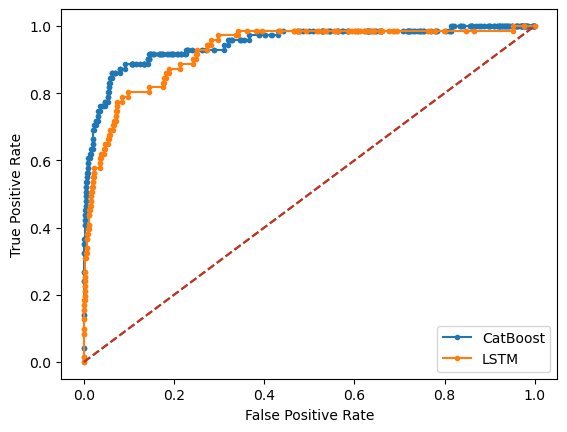

In [136]:
results_no_sample = []
#models = [lr_best_est, svm_best_est, knn_best_est, rf_best_est, xgb_best_est]
models = [xgboost, catboost]
for m in models:
    m.fit(X_train, y_train.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    prec = skmetrics.precision_score(y_test, predicted, zero_division = 0.0)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_no_sample.append([acc, rec, auc])

    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

# LSTM SECTION
X_numpy = np.expand_dims(X_train.values[:,:],axis = 2)
y_numpy = y_train.values[:]
X_numpy_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=32, return_sequences=False, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['Recall'])
model.fit(X_numpy, y_numpy, epochs=100, batch_size=64, validation_data=(X_numpy_test, y_numpy_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_no_sample.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_no_sample)

#Final Plot and Results
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend(['XGBoost', 'CatBoost', 'LSTM'])
pyplot.show()

In [138]:
results_no_sample_uav = []
#models = [lr_best_est, svm_best_est, knn_best_est, rf_best_est, xgb_best_est]
models = [xgboost, catboost]
for m in models:
    m.fit(X_train_uav, y_train.values.ravel())
    predicted = m.predict(X_test_uav)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    prec = skmetrics.precision_score(y_test, predicted, zero_division = 0.0)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_no_sample_uav.append([acc, rec, auc])

    m_probs = m.predict_proba(X_test_uav)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

# LSTM SECTION
X_numpy_uav = np.expand_dims(X_train_uav.values[:,:],axis = 2)
y_numpy = y_train.values[:]
X_numpy_test_uav = np.expand_dims(X_test_uav.values[:,:],axis = 2)
y_numpy_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=32, return_sequences=False, input_shape=(len(X_train_uav.columns), 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['Recall'])
model.fit(X_numpy_test_uav, y_numpy_test, epochs=100, batch_size=64, validation_data=(X_numpy_test_uav, y_numpy_test))

X_numpy_uav = np.expand_dims(X_test_uav.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy_uav).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_no_sample_uav.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels

predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_no_sample)

#Final Plot and Results
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend(['XGBoost', 'CatBoost', 'LSTM'])
pyplot.show()

In [ ]:
def Extract(lst):
    return [item[2] for item in lst]
     
acc_res = Extract(results_no_sample)

In [ ]:
lst1 = acc_res[3::4]


In [ ]:
acc_res_uav = Extract(results_no_sample_uav)

In [ ]:
lst2 = acc_res_uav[3::4]


In [ ]:
f_oneway(lst1, lst2)
tukey_res = tukey_hsd(lst1, lst2)
print(tukey_res)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([lst1, lst2])
ax.set_xticklabels(["lst1", "lst2"]) 
ax.set_ylabel("mean") 
plt.show()

In [ ]:
X_numpy = np.expand_dims(X_train.values[:,:],axis = 2)
y_numpy = y_train.values[:]
X_numpy_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=16, return_sequences=False, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['Recall'])
model.fit(X_numpy, y_numpy, epochs=100, batch_size=64, validation_data=(X_numpy_test, y_numpy_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_no_sample.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_no_sample)

In [ ]:
X_numpy = np.expand_dims(X_train_uav.values[:,:],axis = 2)
y_numpy = y_train.values[:]
X_numpy_test = np.expand_dims(X_test_uav.values[:,:],axis = 2)
y_numpy_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=16, return_sequences=False, input_shape=(len(X_train_uav.columns), 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['Recall'])
model.fit(X_numpy, y_numpy, epochs=100, batch_size=64, validation_data=(X_numpy_test, y_numpy_test))

X_numpy = np.expand_dims(X_test_uav.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_no_sample.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_no_sample)

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.Explainer(lr_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

In [ ]:
explainer = shap.Explainer(svm_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

In [ ]:
explainer = shap.Explainer(knn_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

In [ ]:
explainer = shap.Explainer(rf_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

In [ ]:
explainer = shap.Explainer(xgb_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

In [ ]:
rf_rec_score = cross_val_score(rf, X_test, y_test.values.ravel(), cv=10, scoring="recall")
xgb_rec_score = cross_val_score(xgboost, X_test, y_test.values.ravel(), cv=10, scoring="recall")

rf_rec_score_uav = cross_val_score(rf, X_test_uav, y_test.values.ravel(), cv=10, scoring="recall")
xgb_rec_score_uav = cross_val_score(xgboost, X_test_uav, y_test.values.ravel(), cv=10, scoring="recall")


In [ ]:
rf_prec_score = cross_val_score(rf, X_test, y_test.values.ravel(), cv=10, scoring="precision")
xgb_prec_score = cross_val_score(xgboost, X_test, y_test.values.ravel(), cv=10, scoring="precision")

rf_prec_score_uav = cross_val_score(rf, X_test_uav, y_test.values.ravel(), cv=10, scoring="precision")
xgb_prec_score_uav = cross_val_score(xgboost, X_test_uav, y_test.values.ravel(), cv=10, scoring="precision")

In [ ]:
rf_auc_score = cross_val_score(rf, X_test, y_test.values.ravel(), cv=10, scoring="roc_auc")
xgb_auc_score = cross_val_score(xgboost, X_test, y_test.values.ravel(), cv=10, scoring="roc_auc")

rf_auc_score_uav = cross_val_score(rf, X_test_uav, y_test.values.ravel(), cv=10, scoring="roc_auc")
xgb_auc_score_uav = cross_val_score(xgboost, X_test_uav, y_test.values.ravel(), cv=10, scoring="roc_auc")

In [ ]:
xgb_auc_score

In [ ]:
xgb_auc_score_uav

In [ ]:
f_oneway(xgb_rec_score, xgb_rec_score_uav)


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([xgb_rec_score, xgb_rec_score_uav])
ax.set_xticklabels(["xgb_rec_score", "xgb_rec_score_uav"]) 
ax.set_ylabel("mean") 
plt.show()

In [ ]:
lr_rec_score = cross_val_score(lr_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")
svm_rec_score = cross_val_score(svm_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")
knn_rec_score = cross_val_score(knn_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")
rf_rec_score = cross_val_score(rf_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")
xgb_rec_score = cross_val_score(xgb_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")


In [ ]:
lr_auc_score = cross_val_score(lr_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")
svm_auc_score = cross_val_score(svm_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")
knn_auc_score = cross_val_score(knn_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")
rf_auc_score = cross_val_score(rf_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")
xgb_auc_score = cross_val_score(xgb_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")


In [ ]:
lr_f1_score = cross_val_score(lr_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")
svm_f1_score = cross_val_score(svm_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")
knn_f1_score = cross_val_score(knn_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")
rf_f1_score = cross_val_score(rf_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")
xgb_f1_score = cross_val_score(xgb_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")

In [ ]:
f_oneway(lr_rec_score, svm_rec_score, knn_rec_score, rf_rec_score, xgb_rec_score)


In [ ]:
tukey_res = tukey_hsd(lr_rec_score, svm_rec_score, knn_rec_score, rf_rec_score, xgb_rec_score)
print(tukey_res)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([lr_rec_score, svm_rec_score, knn_rec_score, rf_rec_score, xgb_rec_score])
ax.set_xticklabels(["lr_rec_score", "svm_rec_score", "knn_rec_score", "rf_rec_score", "xgb_rec_score"]) 
ax.set_ylabel("mean") 
plt.show()

In [ ]:
f_oneway(lr_auc_score, svm_auc_score, knn_auc_score, rf_auc_score, xgb_auc_score)
tukey_auc = tukey_hsd(lr_auc_score, svm_auc_score, knn_auc_score, rf_auc_score, xgb_auc_score)
print(tukey_auc)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([lr_auc_score, svm_auc_score, knn_auc_score, rf_auc_score, xgb_auc_score])
ax.set_xticklabels(["lr_auc_score", "svm_auc_score", "knn_auc_score", "rf_auc_score", "xgb_auc_score"]) 
ax.set_ylabel("mean") 
plt.show()

In [ ]:
f_oneway(lr_f1_score, svm_f1_score, knn_f1_score, rf_f1_score, xgb_f1_score)
tukey_f1 = tukey_hsd(lr_f1_score, svm_f1_score, knn_f1_score, rf_f1_score, xgb_f1_score)
print(tukey_f1)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([lr_f1_score, svm_f1_score, knn_f1_score, rf_f1_score, xgb_f1_score])
ax.set_xticklabels(["lr_f1_score", "svm_f1_score", "knn_f1_score", "rf_f1_score", "xgb_f1_score"]) 
ax.set_ylabel("mean") 
plt.show()

# CREATE SAMPLED AND AUGMENTED DATA

# Undersampling

In [ ]:
results_under = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_final_under, y_final_under.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_under.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [ ]:
X_numpy_under = np.expand_dims(X_final_under.values[:,:],axis = 2)
y_numpy_under = y_final_under.values[:]
X_numpy_under_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_under_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(len(X_final_under.columns), 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['Recall'])
model.fit(X_numpy_under, y_numpy_under, epochs=25, batch_size=16, validation_data=(X_numpy_under_test, y_numpy_under_test))
ypred = model.predict(X_numpy_under_test).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy_under_test, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy_under_test, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy_under_test, ypred)
auc = bauc.result().numpy()

results_under.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy_under_test, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_under)

# Oversampling

In [ ]:
results_over = []
models = [lr, knn, rf, ada]
for m in models:
    m.fit(X_final_over, y_final_over.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_over.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
X_numpy_over = np.expand_dims(X_final_over.values[:,:],axis = 2)
y_numpy_over = y_final_over.values[:]
X_numpy_over_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_over_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_over.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_over, y_numpy_over, epochs=25, batch_size=64, validation_data=(X_numpy_over_test, y_numpy_over_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_over.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_over)

# Hybrid

In [ ]:
final_oversample_1 = RandomOverSampler(sampling_strategy=0.3)
X_final_over_1, y_final_over_1 = final_oversample_1.fit_resample(X_train, y_train)
X_final_ou, y_final_ou = final_undersample.fit_resample(X_final_over_1, y_final_over_1)

In [ ]:
print("Number of malicious records: ", y_final_ou.value_counts()[1])
print("Number of normal records: ", y_final_ou.value_counts()[0])

In [ ]:
results_ou = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_final_ou, y_final_ou.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_ou.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot

In [ ]:
X_numpy_ou = np.expand_dims(X_final_ou.values[:,:],axis = 2)
y_numpy_ou = y_final_ou.values[:]
X_numpy_ou_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_ou_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_over.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_ou, y_numpy_ou, epochs=25, batch_size=64, validation_data=(X_numpy_ou_test, y_numpy_ou_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_ou.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_ou)

# SMOTE

In [ ]:
results_smote = []
models = [lr, rf, xgboost]

for m in models:
    m.fit(X_smote, y_smote.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_smote.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(['Logistic Regression', 'Random Forrest', 'XG Boost'])
# show the plot
pyplot.show()

In [ ]:
results_smote = []
models = [lr, rf, xgboost]

for m in models:
    m.fit(X_smote_uav, y_smote_uav.values.ravel())
    predicted = m.predict(X_test_uav)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_smote.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test_uav)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(['Logistic Regression', 'Random Forrest', 'XG Boost'])
# show the plot
pyplot.show()

In [ ]:
X_numpy_smote = np.expand_dims(X_final_smote.values[:,:],axis = 2)
y_numpy_smote = y_final_smote.values[:]
X_numpy_smote_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_smote_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_smote.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_ou, y_numpy_ou, epochs=25, batch_size=64, validation_data=(X_numpy_ou_test, y_numpy_ou_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_smote.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_ou)

# ADASYN

In [ ]:
# X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_final_adasyn, y_final_adasyn, test_size=0.3)

In [ ]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# ada_lr_best_est = grid.best_estimator_



In [ ]:

# #linear failed to converge
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# ada_svm_best_est = grid.best_estimator_



In [ ]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# ada_knn_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn, y_train_adasyn.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# ada_rf_best_est = grid.best_estimator_


In [ ]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn, y_train_adasyn.values.ravel())
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# ada_ada_best_est = grid.best_estimator_

In [ ]:
# #Adapt from above
# lr = ada_lr_best_est
# svm = ada_svm_best_est
# knn = ada_knn_best_est
# rf = ada_rf_best_est
# ada = ada_ada_best_est


In [ ]:
results_ada = []
models = [rf, xgboost]

for m in models:
    m.fit(X_ada, y_ada.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_ada.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot

In [ ]:
results_ada_uav = []
models = [rf, xgboost]

for m in models:
    m.fit(X_ada_uav, y_ada_uav.values.ravel())
    predicted = m.predict(X_test_uav)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_ada_uav.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test_uav)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot

In [ ]:
# results_adasyn = []
# models = [lr, svm, knn, rf, ada]

# for m in models:
#     m.fit(X_train_adasyn, y_train_adasyn.values.ravel())
#     predicted = m.predict(X_test)
#     acc = skmetrics.accuracy_score(y_test, predicted)
#     rec = metrics.recall_score(y_test, predicted)
#     prec = metrics.precision_score(y_test, predicted)
#     f1 = metrics.f1_score(y_test, predicted)
#     auc = metrics.roc_auc_score(y_test, predicted)
#     results_adasyn.append([acc, rec, prec, f1, auc])
#     m_probs = m.predict_proba(X_test)
#     m_probs = m_probs[:, 1]
#     m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
#     pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

# X_numpy_adasyn = np.expand_dims(X_train_adasyn.values[:,:],axis = 2)
# y_numpy_adasyn = y_train_adasyn.values[:]
# X_numpy_adasyn_test = np.expand_dims(X_test_adasyn.values[:,:],axis = 2)
# y_numpy_adasyn_test = y_test_adasyn.values[:]
# model = Sequential()
# model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
# model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

# X_numpy = np.expand_dims(X_test.values[:],axis = 2)
# y_numpy = y_test.values[:]
# ypred = model.predict(X_numpy).ravel()

# ba = tf.keras.metrics.BinaryAccuracy()
# ba.update_state(y_numpy, ypred)
# acc = ba.result().numpy()

# br = tf.keras.metrics.Recall()
# br.update_state(y_numpy, ypred)
# rec = br.result().numpy()

# bp = tf.keras.metrics.Precision()
# bp.update_state(y_numpy, ypred)
# prec = bp.result().numpy()

# # bf1 = tf.keras.metrics.F1Score()
# # bf1.update_state(y_numpy, ypred)
# # f1 = bf1.result().numpy()

# bauc = tf.keras.metrics.AUC()
# bauc.update_state(y_numpy, ypred)
# auc = bauc.result().numpy()

# results_adasyn.append([acc, rec, prec, auc])

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
# pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
# ns_probs = [0 for _ in range(len(y_test))]
# ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()
# print(results_adasyn)

# Borderline SMOTE

In [ ]:
X_train_blsmote, X_test_blsmote, y_train_blsmote, y_test_blsmote = train_test_split(X_final_blsmote, y_final_blsmote, test_size=0.3)

In [ ]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# bls_lr_best_est = grid.best_estimator_



In [ ]:

# #linear failed to converge
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# bls_svm_best_est = grid.best_estimator_

In [ ]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# bls_knn_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote, y_train_blsmote.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# bls_rf_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote, y_train_blsmote)
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# bls_ada_best_est = grid.best_estimator_

In [ ]:
# #Adapt from above
# lr = LogisticRegression(max_iter=1000)
# svm = SVC(probability=True)
# knn = bls_knn_best_est
# rf = bls_rf_best_est
# ada = bls_ada_best_est

In [ ]:
results_blsmote = []
models = [lr, svm, knn, rf, ada]

for m in models:
    m.fit(X_train_blsmote, y_train_blsmote.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    results_blsmote.append([acc, rec, prec, f1, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

X_numpy_blsmote = np.expand_dims(X_train_blsmote.values[:,:],axis = 2)
y_numpy_blsmote = y_train_blsmote.values[:]
X_numpy_blsmote_test = np.expand_dims(X_test_blsmote.values[:,:],axis = 2)
y_numpy_blsmote_test = y_test_blsmote.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_blsmote.append([acc, rec, prec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_blsmote)

In [ ]:
# sb.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

EXPERIMENT SECTION

In [ ]:
param_grid = {
     'n_estimators': [100, 200, 300],
     'learning_rate': [0.01, 0.05, 0.1, 1],
     'algorithm': ['SAMME', 'SAMME.R']
 }
grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
grid.fit(X_final_under, y_final_under.values.ravel())
print("ADA Best estimater:", grid.best_estimator_)
print("ADA Best parameters:", grid.best_params_)
print("ADA Best score:", grid.best_score_)
ada_ada_best_est = grid.best_estimator_
ada = ada_ada_best_est

results_under = pd.DataFrame(columns=['model', 'acc', 'rec', 'auc'])
for e in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # X_test.drop(columns=[10000], inplace=True)
    # X_train.drop(columns=[10000], inplace=True)

    # X_test.drop(columns=[10000, 10007, 10009, 10011, 10012, 10008, 10010], inplace=True)
    # X_train.drop(columns=[10000, 10007, 10009, 10011, 10012, 10008, 10010], inplace=True)

    # X_test = X_test[[10007, 10009, 10011, 10012, 10008, 10010]]
    # X_train = X_train[[10007, 10009, 10011, 10012, 10008, 10010]]

    # X_test.drop(columns=[10000, 10007, 10009, 10011, 10012], inplace=True)
    # X_train.drop(columns=[10000, 10007, 10009, 10011, 10012], inplace=True)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    final_undersample = RandomUnderSampler(sampling_strategy='majority')
    X_final_under, y_final_under = final_undersample.fit_resample(X_train, y_train)
    final_under = X_final_under.copy()
    final_under['label'] = y_final_under

    final_oversample = RandomOverSampler(sampling_strategy='minority')
    X_final_over, y_final_over = final_oversample.fit_resample(X_train, y_train)
    final_over = X_final_over.copy()
    final_over['label'] = y_final_over

    final_smote = SMOTE(k_neighbors=10)
    X_final_smote, y_final_smote = final_smote.fit_resample(X_train, y_train)
    final_smote = X_final_smote.copy()
    final_smote['label'] = y_final_smote

    final_blsmote = BorderlineSMOTE(k_neighbors=10)
    X_final_blsmote, y_final_blsmote = final_blsmote.fit_resample(X_train, y_train)
    final_blsmote = X_final_blsmote.copy()
    final_blsmote['label'] = y_final_blsmote

    final_adasyn = ADASYN(n_neighbors=10)
    X_final_adasyn, y_final_adasyn = final_adasyn.fit_resample(X_train, y_train)
    final_adasyn = X_final_adasyn.copy()
    final_adasyn['label'] = y_final_adasyn

    models = [lr, knn, rf, ada]
    for m in models:
        m.fit(X_final_under, y_final_under.values.ravel())
        predicted = m.predict(X_test)
        acc = skmetrics.accuracy_score(y_test, predicted)
        rec = skmetrics.recall_score(y_test, predicted)
        auc = skmetrics.roc_auc_score(y_test, predicted)
        results_under.loc[len(results_under.index)] = [m, acc, rec, auc] 


    X_numpy_under = np.expand_dims(X_final_under.values[:,:],axis = 2)
    y_numpy_under = y_final_under.values[:]
    X_numpy_under_test = np.expand_dims(X_test.values[:,:],axis = 2)
    y_numpy_under_test = y_test.values[:]
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_under.columns), 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    model.fit(X_numpy_under, y_numpy_under, epochs=10, batch_size=16, validation_data=(X_numpy_under_test, y_numpy_under_test))
    ypred = model.predict(X_numpy_under_test).ravel()

    ba = tf.keras.metrics.BinaryAccuracy()
    ba.update_state(y_numpy_under_test, ypred)
    acc = ba.result().numpy()

    br = tf.keras.metrics.Recall()
    br.update_state(y_numpy_under_test, ypred)
    rec = br.result().numpy()

    bauc = tf.keras.metrics.AUC()
    bauc.update_state(y_numpy_under_test, ypred)
    auc = bauc.result().numpy()

    results_under.loc[len(results_under.index)] = ['lstm', acc, rec, auc] 
    results_under

results_under.to_excel("/Users/ken.clements/Desktop/results6.xlsx")